## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df[df['converted']==1].shape[0] / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.groupby(['group','landing_page']).size().unstack()

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Creating new dataframe excluding the rows where group and landing_page don't align
df2 = df[ ~((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')) & ~((df['group'] == 'control') & (df['landing_page'] == 'new_page'))]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates(['user_id'], inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2[df2['converted']==1].shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control = df2[(df2['group']=='control') & (df2['converted'] == 1)].shape[0]/df2[df2['group']=='control'].shape[0]
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment = df2[(df2['group']=='treatment') & (df2['converted'] == 1)].shape[0]/df2[df2['group']=='treatment'].shape[0]
p_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2[df2['landing_page']=='new_page'].shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

- Probability of conversion regardless of the page received = 11.96%
- Probability of user conversion through the new page (treatment group) = 11.88%
- Probabiltiy of user conversion through the old page (control group) = 12%
- Probabiltiy of receiving the new page = 50% 

Observation: Having an equal chance of receiving either the old or new page, the probability of conversion on the old page is slightly higher than the new page, even higher than the general probability of conversion on either pages. 

Conclusion: New page doesn't generate higher conversion rate. Thus, we are better off with the old page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: P_{old} - P_{new} \ge 0$$

$$H_1: P_{old} - P_{new} \lt 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([1,0], n_new, p=[p_new, (1-p_old)])
new_page_converted

array([0, 0, 1, ..., 1, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([1,0], n_old, p=[p_old, (1-p_old)])
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
(new_page_converted.mean()/n_new)  - (old_page_converted.mean()/n_old)

1.186079577952286e-08

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
new_page_conversions = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_conversions = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_conversions - old_page_conversions
p_diffs

array([-1.19297539e-03,  8.99502673e-04, -5.71786566e-05, ...,
        1.69786078e-03,  1.03726053e-03,  6.44953084e-04])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

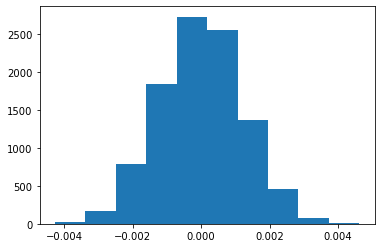

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
obs_diff = p_treatment - p_control
(p_diffs > obs_diff).mean()

0.8983

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** The p-value for our hypothesis is 0.8983, which is greater than the Type I error threshold of 0.05. This means, that we can't reject the null hypothesis. In conclusion, we should accept that the old page generate more or the same conversion rate than that of the new page, and we shall accept the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score,p_value

(1.3109241984234394, 0.9050583127590245)

In [30]:
from scipy.stats import norm

# Calculate the significance of the z-score
print(norm.cdf(z_score))

# Calculate the critical value under 95% confidence interval
print(norm.ppf(1-0.05))

0.9050583127590245
1.6448536269514722


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score is less than the critical value, which means we can't reject the null hypothesis, making it similar to the previous parts in j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
# Create dummy variables in ab_page column
df2['ab_page'] = pd.get_dummies(df2['landing_page'])['new_page']
# Create the intercept column
df2['intercept'] = 1
# Check
df2

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1
...,...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,0,1
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,0,1
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,0,1
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
# Create the logistic regression model using Logit
mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
# Fit the model
results = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
# View results summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 10 Jan 2021   Pseudo R-squ.:               8.077e-06
Time:                        22:27:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [34]:
# Get the exponent of the parameters values to interpret it
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

Observation:

- Users who land on the new page are 0.98 more likely to convert than users who land on the old page. 


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

P-value of ab_page is 0.190. It differs than the value we found in part 2 as The test in part 2 is a one tailed test while this one is a two tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Many other factors might affect the conversion process. Here we only have one parameter which is the landing page, but that is not descriptive enough to understand how would the page influence the customer's decision. Things like the placing of certain buttons or sections of interest within the page, it might be helpful to know how the customer interacts with different elements in the page. Of course, other factors such as the variety of products or services the website offers, methods of payment, quality of content in the page, and many other factors will have an impact over the customer's experience.**

Disadvantage of adding more terms would be:
- Increased variance of the model
- Multicollinearity problem

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [36]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [37]:
### Fit Your Linear Model And Obtain the Results
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'CA']])
results2 = mod.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 10 Jan 2021   Pseudo R-squ.:               1.521e-05
Time:                        22:27:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

In [38]:
# Get exponents of the parameters to interpret it
np.exp(results2.params)

intercept    0.135779
UK           1.009966
CA           0.960018
dtype: float64

Observations: 

- Users in UK would be 1.009 more likely to convert than users in the USA.
- Users in Canada would be 0.96 more likely to convert than users in USA.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
df_new['UK*abPage'] = df_new['ab_page'] * df_new['UK']
df_new['CA*abPage'] = df_new['ab_page'] * df_new['CA']
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,UK*abPage,CA*abPage
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [42]:
mod = sm.Logit(df_new['converted'], df_new[['intercept','UK','CA','UK*abPage', 'CA*abPage']])
results3 = mod.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Sun, 10 Jan 2021   Pseudo R-squ.:               2.417e-05
Time:                        22:28:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2729
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0045      0.018      0.257      0.797      -0.030       0.039
CA            -0.0073      0.037     -0.196      0.844      -0.080       0.065
UK*abPage      0.0108      0.023      0.475      0.635      -0.034       0.056
CA*abPage     -0.0674      0.052     -1.297      0.195      -0.169       0.034
==============================================================================
"""

In [43]:
np.exp(results3.params)

intercept    0.135779
UK           1.004517
CA           0.992750
UK*abPage    1.010893
CA*abPage    0.934776
dtype: float64

Obervations:
- Users in the UK who are using the new page are 1.010 times more likely to make a conversion than users in the US using the old page.
- Users in Canada who are using the new page are 0.934 times more likely to make a conversion than those in the US using the old page
- Users in the UK are 1.004 times more likely to make a conversion than users in the US, regardless of the page they receive.
- Users in Canada are 0.992 times more likely to make a conversion than users in the US, regardless of the page they receive

<a id='conclusions'></a>
## Conclusions

Calculations wrap-up:

P-values: 
- 0.190 for the new page
- 0.456 for UK
- 0.129 for Canada
- 0.635 for users in the UK using the new page
- 0.195 for users in Canada using the new page

Coeffs:
- Using the new page in UK    1.010
- Using the new page in CA    0.934
- Users in UK           1.009
- Users in CA           0.960
- Using the new page      0.985

We can notice that these results are neither statistically significant when we look at the p-value, neither are they practically significant looking at their coefficients.

This confirms the observartions we had using probabilites, A/B testing, and regression models. That is the old page is slightly better than the new page. Therefore, we can keep the old page and disregard the new one.